In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
sys.path.append(parent_dir)

# Regular Imports
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

import inference.scheduler
from inference.distribution import Gaussian, GaussianMixture, Rosenbrock2D, InterpolatedDensity
from inference.sde import EulerMaruyamaSimulator, LangevinDynamics
import utils.vis2d.visualization

In [3]:
class LinearInterpolatedDensity(InterpolatedDensity):

    def __init__(self, density0, density1):
        super().__init__(density0, density1)
    
    def interpolate(self, log_density0: torch.Tensor, log_density1: torch.Tensor, alpha: float) -> torch.Tensor:
        """
        Constructs interpolation between density0 and density1
        Args:
            - log_density0 (torch.Tensor): Log density of density0 evaluated at x
            - log_density1 (torch.Tensor): Log density of density1 evaluated at x
            - alpha (float): Interpolation parameter (0 <= alpha <= 1)
        """
        return log_density0 + alpha * (log_density1 - log_density0)

# Write Up
Write up of this expeirment is at https://docs.google.com/presentation/d/11G0fuKPtKkklu-rn0dTnIIRiQ9SCsBF4By0rgdhf2YY/edit?usp=sharing

# Unit 1: Various Measures of Rate of Change of Score
# Experiment 1: Rate of Change of Fisher Divergence

Consider an interpolated density $p_t = F[p_0, p_1, t]$ which interpolates between an initial (easy) density $p_0$ and a final (hard) density $p_1$.

We can figure out how fast $p_t$ is moving away from $p_0$ by computing the rate of change of the Fisher divergence

$$
\frac{d}{dt} D_F(p_0 || p_t)  = 2~\mathbb E_{p_0} \left[s_t \cdot \frac{ds_t}{dt} + \nabla_x \cdot \frac{ds_t}{dt} \right]
$$
where $s_t = \nabla_x \log p_t(x)$ is the score function of $p_t$.

**In linear interpolation** (that is $F[p_0, p_1, t] = (1-t)p_0 + tp_1$), we have
$$
\frac{d}{dt} D_F(p_0 || p_t)  = 2~\mathbb E_{p_0} \Big[ -(1-t) s_0^2 + t s_1^2 + (1-2t) s_0 \cdot s_1 - \nabla_x \cdot s_0 + \nabla_x \cdot s_1\Big]
$$

In [6]:
import torch

def divergence(func, x):
    """
    Compute the divergence of `func` evaluated at `x`.
    
    Args:
        func: function from (batch_size, 2) → (batch_size, 2)
        x: torch.Tensor of shape (batch_size, 2), requires_grad=True
    
    Returns:
        divergence: torch.Tensor of shape (batch_size,)
    """
    assert x.requires_grad, "Input x must have requires_grad=True"

    y = func(x)  # (batch_size, 2)
    div = torch.zeros(x.shape[0], device=x.device)

    for i in range(2):  # Loop over x and y dimensions
        grad_outputs = torch.zeros_like(y)
        grad_outputs[:, i] = 1.0  # Select i-th component
        grad = torch.autograd.grad(
            outputs=y,
            inputs=x,
            grad_outputs=grad_outputs,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]  # (batch_size, 2)
        div += grad[:, i]  # accumulate ∂f_i/∂x_i
    
    return div  # (batch_size,)


from inference.distribution import Sampleable, Density
def rateofchange(t, 
                 density0: Density,
                 density1: Density, 
                 num_samples: int = 1000) -> float:
    samples = density0.sample(num_samples=num_samples)
    score0 = density0.score(samples)
    score1 = density1.score(samples)

    # Terms
    term1 = -1 * (1-t) * torch.einsum('bi, bi -> b', score0, score0) # (num_samples,)
    term2 = t * torch.einsum('bi, bi -> b', score1, score1) #(num_samples,)
    term3 = (1 - 2*t) * torch.einsum('bi, bi -> b', score0, score1)  # (num_samples,)

    samples.requires_grad_(True)
    term4 = -1 * divergence(density0.score, samples)
    term5 = divergence(density1.score, samples)

    # Average terms
    term1 = torch.mean(term1)
    term2 = torch.mean(term2)
    term3 = torch.mean(term3)
    term4 = torch.mean(term4)
    term5 = torch.mean(term5)

    # Result
    return 2 * (term1 + term2 + term3 + term4 + term5)

## Unit Gaussian -> Gaussian Mixture

100%|██████████| 50/50 [00:01<00:00, 25.33it/s]


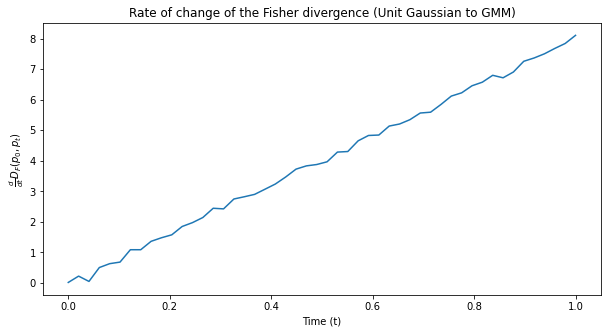

In [7]:
nmodes = 5
std = 1.0
scale = 20.0
seed = 1

density0 = Gaussian(mean=torch.zeros(2), cov=torch.eye(2))
density1 = GaussianMixture.random_2D(nmodes=nmodes, 
                                     std=std, 
                                     scale=scale, 
                                     seed=seed)
dist_interpolated = LinearInterpolatedDensity(density0=density0, density1=density1) # Interpolated density

times = torch.linspace(0, 1, 50)
rates = [rateofchange(t, density0, density1, num_samples=5000).detach().numpy() for t in tqdm(times)]


fig = plt.figure(figsize=(10, 5))

plt.plot(times, rates)

plt.xlabel('Time (t)')
plt.ylabel(r'$\frac{d}{dt}D_F(p_0, p_t)$')
plt.title('Rate of change of the Fisher divergence (Unit Gaussian to GMM)')
plt.show()

# Unit Gaussian to Rosenbrock

100%|██████████| 50/50 [00:00<00:00, 57.64it/s]


Text(0.5, 1.0, 'Rate of change of the Fisher divergence (Unit Gaussian to Rosenbrock)')

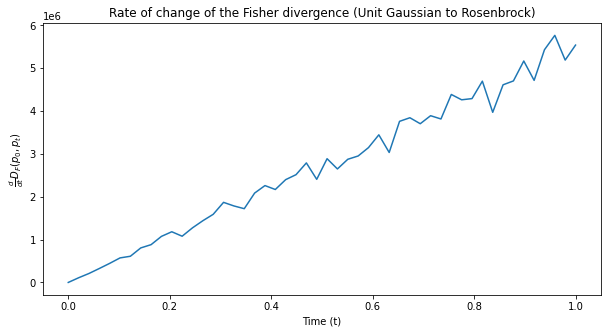

In [8]:
nmodes = 5
std = 1.0
scale = 20.0
seed = 1

density0 = Gaussian(mean=torch.zeros(2), cov=torch.eye(2))
density1 = Rosenbrock2D()
dist_interpolated = LinearInterpolatedDensity(density0=density0, density1=density1) # Interpolated density

times = torch.linspace(0, 1, 50)
rates = [rateofchange(t, density0, density1, num_samples=10000).detach().numpy() for t in tqdm(times)]


fig = plt.figure(figsize=(10, 5))

plt.plot(times, rates)

plt.xlabel('Time (t)')
plt.ylabel(r'$\frac{d}{dt}D_F(p_0, p_t)$')
plt.title('Rate of change of the Fisher divergence (Unit Gaussian to Rosenbrock)')

I originally thought this result was due to numerical error (look at the scale of the y-axis), but if you do the calculation in Mathematica, you get the same result... Seems like the Fisher divergence doesn't capture the change ideally...

# Experiment 2: Rate of Change measured Empirically

One can construct more empirical measures of rate of change of the score. For example consider this measure
$$
E_{p_s}\left[ \left(\frac{ds_t}{dt}\right)^2 \right]
$$
where samples $x^{(s)} \sim p_s$ using our Langevin Dyanamics simulator

In [ ]:
from functorch import jacrev
from inference.distribution import Density

def measure(t: torch.Tensor,
            samples: torch.Tensor,
            interpolated_density: InterpolatedDensity) -> float:
    '''
    Args:
        t (torch.Tensor): Time `t` of interpolation. Single value torch tensor, w/ required_grad=True
        samples (torch.Tensor): shape (num_samples, dim)
        interpolated_density (InterpolatedDensity): Interpolation method.
    '''
    
    def score_wrapper(t):
        return interpolated_density.score(samples, alpha=t) # (num_samples, dim)

    ds_dt = jacrev(score_wrapper)(t)  # shape: (batch_size, dim)

    dotprod = torch.einsum('bi, bi -> b', ds_dt, ds_dt)

    return torch.mean(dotprod)

In [ ]:
def run(dist: InterpolatedDensity, 
        x: torch.Tensor, 
        ts: torch.Tensor,
        noise_scheduler: inference.scheduler.Scheduler,
        interpolant_steps: torch.Tensor,) -> torch.Tensor:    
    '''
    Runs Annealed Importance Sampling w/ Unadjusted Langevin, interpolating between two distributions.
    Saves intermediate steps (after interpolating step).

    Args:
        - x: Initial positions of samples. Shape (batch_size, dim)
        - ts: Time steps for LangevinDynamics. Shape (times,)
        - noise_scheduler: 
        - interpolant_steps: Steps with values between [0,1]. Shape (interpolant_size, )

    Returns
        - Shape (batch_size, interpolant_size, dim)
    '''
    # Run Simulation
    xs = [x.clone()] 
    rateofchanges = [0.0, ]
    for step_pct in tqdm(interpolant_steps):
        # Langevin Dynamics
        score = lambda x, _: dist.score(x, alpha=step_pct)
        sde = LangevinDynamics(score=score, 
                               noise_scheduler=noise_scheduler)
        simulator = EulerMaruyamaSimulator(sde=sde)
        x = simulator.simulate(x=x, ts=ts) # shape (batch_size, dim)
        
        # Calculate rate of change of score
        change = measure(t=step_pct, samples=x, interpolated_density=dist)

        # Record results
        xs.append(x.clone())
        rateofchanges.append(change)

    return (torch.stack(xs, dim=1), # Shape (batch_size, interpolant_steps, dim)
            torch.tensor(rateofchanges) # (interpolant_steps)
            )

def plot_interpolated(times , samples,)

  0%|          | 0/13 [00:00<?, ?it/s]/Users/clarkmiyamoto/opt/anaconda3/lib/python3.9/site-packages/torch/_functorch/deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacrev')
100%|██████████| 13/13 [00:57<00:00,  4.45s/it]


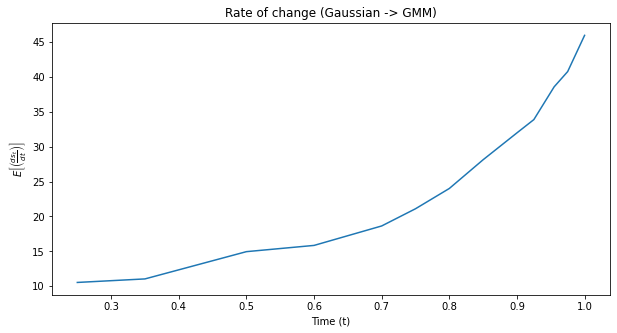

In [41]:
nmodes = 5
std = 1.0
scale = 20.0
seed = 1

density0 = Gaussian(mean=torch.zeros(2), cov=torch.eye(2))
density1 = GaussianMixture.random_2D(nmodes=nmodes, 
                                     std=std, 
                                     scale=scale, 
                                     seed=seed)
dist_interpolated = LinearInterpolatedDensity(density0=density0, density1=density1) # Interpolated density

####
x0 = density0.sample(1000)
num_steps, step_size = 1000, 0.01
ts = torch.arange(0, num_steps * step_size, step_size)
noise_scheduler = inference.scheduler.Linear(3.0, 0.5)
interpolant_steps = torch.tensor([0.25, 0.35, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.925, 0.955, 0.975, 1.0])

### Runs imulation
samples, rateofchange = run(dist=dist_interpolated,
                            x=x0,
                            ts=ts,
                            noise_scheduler=noise_scheduler,
                            interpolant_steps=interpolant_steps)

fig = plt.figure(figsize=(10, 5))

plt.plot(interpolant_steps.cpu().detach().numpy(), rateofchange.cpu().detach().numpy()[1:])
plt.xlabel('Time (t)')
plt.ylabel(r'$E \left[ \left (\frac{ds_t}{dt} \right ) \right ]$')
plt.title('Rate of change (Gaussian -> GMM)')
plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]/Users/clarkmiyamoto/opt/anaconda3/lib/python3.9/site-packages/torch/_functorch/deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacrev')
100%|██████████| 9/9 [00:44<00:00,  4.91s/it]


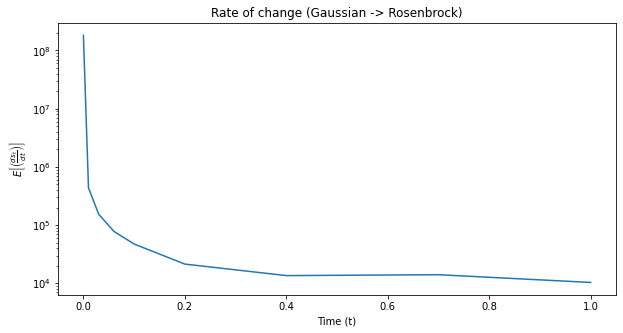

In [47]:
### Setup
# Distribution Setup
seed = 1

density0 = Gaussian(mean=torch.zeros(2), cov=torch.eye(2))
density1 = Rosenbrock2D(a=100,b=1.0) # target distribution

# Simulator setup
x0 = density0.sample(num_samples=1000)
num_steps, step_size = 1000, 0.001
ts = torch.arange(0, num_steps * step_size, step_size)
noise_scheduler = inference.scheduler.Linear(3.0, 0.5)
interpolant_steps = torch.tensor([0.0, 0.01, 0.03, 0.06, 0.1, 0.2, 0.4, 0.7, 1.0])

### Code
# Setup up
dist_interpolated = LinearInterpolatedDensity(density0=density0, density1=density1) # Interpolated density

### Runs imulation
samples, rateofchange = run(dist=dist_interpolated,
                            x=x0,
                            ts=ts,
                            noise_scheduler=noise_scheduler,
                            interpolant_steps=interpolant_steps)

fig = plt.figure(figsize=(10, 5))

plt.plot(interpolant_steps.cpu().detach().numpy(), rateofchange.cpu().detach().numpy()[1:])

plt.xlabel('Time (t)')
plt.ylabel(r'$E \left[ \left (\frac{ds_t}{dt} \right ) \right ]$')
plt.yscale('log')
plt.title('Rate of change (Gaussian -> Rosenbrock)')
plt.show()

# Unit 2: Determining Update Step